In [1]:
!wget -q https://git.io/J0fjL -O IAM_Words.zip
!unzip -qq IAM_Words.zip
!mkdir data
!mkdir data/words
!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data/words
!unzip drive/MyDrive/Dataset/lines.zip -d data/lines

Výstup streamovania bol skrátený na tento počet posledných riadkov: 5000.
  inflating: data/lines/lines/img/h07/h07-028/h07-028-10.png  
   creating: data/lines/lines/img/h07/h07-028a/
  inflating: data/lines/lines/img/h07/h07-028a/h07-028a-00.png  
  inflating: data/lines/lines/img/h07/h07-028a/h07-028a-01.png  
  inflating: data/lines/lines/img/h07/h07-028a/h07-028a-02.png  
  inflating: data/lines/lines/img/h07/h07-028a/h07-028a-03.png  
  inflating: data/lines/lines/img/h07/h07-028a/h07-028a-04.png  
  inflating: data/lines/lines/img/h07/h07-028a/h07-028a-05.png  
  inflating: data/lines/lines/img/h07/h07-028a/h07-028a-06.png  
  inflating: data/lines/lines/img/h07/h07-028a/h07-028a-07.png  
 extracting: data/lines/lines/img/h07/h07-028a/h07-028a-08.png  
   creating: data/lines/lines/img/h07/h07-030/
  inflating: data/lines/lines/img/h07/h07-030/h07-030-00.png  
  inflating: data/lines/lines/img/h07/h07-030/h07-030-01.png  
  inflating: data/lines/lines/img/h07/h07-030/h07-030-02.

In [2]:
!pip install editdistance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
from pathlib import Path
from tqdm import tqdm
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import cv2

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
characters = " |!\"#%&'()*+,-./0123456789:;=?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz´ÁÉÍÓÔÚÝáéíúýĆČčĎĽľŇňŠšŤťŽž€"

samples = []
max_len = 64
out = 0
def update_samples(labels_path, img_root_path):
  global samples, out
  with open(labels_path, 'r', encoding="utf-8") as f:
      for idx, line in tqdm(enumerate(f)):
          # if idx > 2000:
          #   break
          if line[0] == '#':
              continue
          line = line.split(' ')
          if line[1] != 'ok':
              continue

          name = line[0].split('-')
          img_path = "/".join([img_root_path, name[0], f"{name[0]}-{name[1]}", line[0]]) + ".png"
          gt_text = " ".join(line[8:]).strip()

          if len(gt_text) >= max_len:
            out += 1
            continue

          if not os.path.getsize(img_path) or len(gt_text)==0:
            print(img_path)
            continue

          samples.append((img_path, gt_text))


update_samples("data/lines/lines/gt/lines.txt", "data/lines/lines/img")
# update_samples("data/words/words.txt", "data/words")
np.random.shuffle(samples)

split_idx = int(len(samples)*0.9)
samples_trian = samples[:split_idx]
samples_validation = samples[split_idx:]
characters = sorted(list(characters))

print("Samples", len(samples))
print("Out", out)

13397it [00:00, 184463.51it/s]

Samples 11134
Out 231


In [5]:
# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=characters)
# Mapping integers back to original characters.
num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), invert=True)

In [6]:
batch_size = 32
image_width = 256
image_height = 32
padding_token = 120

tf.data.experimental.enable_debug_mode()

def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

def augmentation(imgs,
                 rotation_range=5,
                 scale_range=0.1,
                 height_shift_range=0.05,
                 width_shift_range=0.1,
                 dilate_range=1,
                 erode_range=1):
    """Apply variations to a list of images (rotate, width and height shift, scale, erode, dilate)"""
    # Conver tensor to numpy array
    imgs = imgs.numpy()
    imgs = imgs.astype(np.float32)
    _, h, w = imgs.shape


    dilate_kernel = np.ones((int(np.random.uniform(1, dilate_range)),), np.uint8)
    erode_kernel = np.ones((int(np.random.uniform(1, erode_range)),), np.uint8)
    height_shift = np.random.uniform(-height_shift_range, height_shift_range)
    rotation = np.random.uniform(-rotation_range, rotation_range)
    scale = np.random.uniform(1 - scale_range, 1)
    width_shift = np.random.uniform(-width_shift_range, width_shift_range)
    

    trans_map = np.float32([[1, 0, width_shift * w], [0, 1, height_shift * h]])
    rot_map = cv2.getRotationMatrix2D((w // 2, h // 2), rotation, scale)

    trans_map_aff = np.r_[trans_map, [[0, 0, 1]]]
    rot_map_aff = np.r_[rot_map, [[0, 0, 1]]]
    affine_mat = rot_map_aff.dot(trans_map_aff)[:2, :]

    for i in range(len(imgs)):
        imgs[i] = cv2.warpAffine(imgs[i], affine_mat, (w, h), flags=cv2.INTER_NEAREST, borderValue=255)
        imgs[i] = cv2.erode(imgs[i], erode_kernel, iterations=1)
        imgs[i] = cv2.dilate(imgs[i], dilate_kernel, iterations=1)
        

    return imgs

def augmentation_ds(sample):
    image = sample["image"]
    label = sample["label"]
    # wrap the augmentation function in a tf.py_function
    image = tf.squeeze(image)
    image = tf.py_function(augmentation, [image], tf.float32)
    
    # image = augmentation(image.numpy(), rotation_range=5, scale_range=0.1, height_shift_range=0.05, width_shift_range=0.1, dilate_range=2, erode_range=2)
    # add back last dimension
    image = tf.expand_dims(image, axis=-1)
    
    return {"image": image, "label": label}

def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label

def process_images_labels(sample):
    image = preprocess_image(sample[0])
    label = vectorize_label(sample[1])
    
    # return image, label
    return {"image": image, "label": label}

In [7]:
def prepare_dataset(samples):
    dataset = tf.data.Dataset.from_tensor_slices(samples).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.padded_batch(batch_size).cache().prefetch(AUTOTUNE)

train_ds = prepare_dataset(samples_trian)
validation_ds = prepare_dataset(samples_validation)
aug_train_ds = train_ds.map(augmentation_ds, num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)

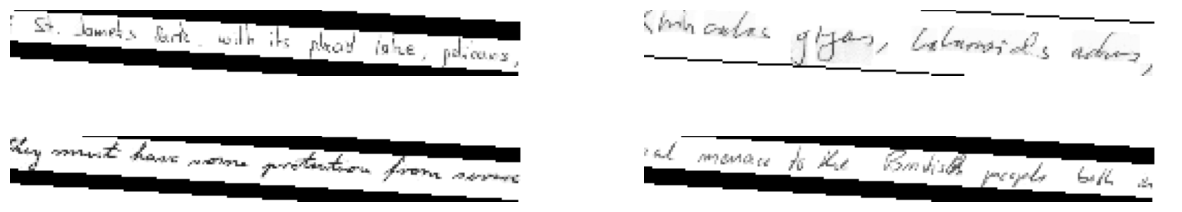

In [8]:
for data in aug_train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(2, 2, figsize=(15, 3))

    for i in range(4):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        # label = labels[i]
        # indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # # Convert to string.
        # label = tf.strings.reduce_join(num_to_char(indices))
        # label = label.numpy().decode("utf-8")

        ax[i // 2, i % 2].imshow(img, cmap="gray")
        # ax[i // 4, i % 4].set_title(label)
        ax[i // 2, i % 2].axis("off")


plt.show()

In [9]:
from tensorflow.compat.v1.keras.layers import CuDNNLSTM

class CTCLayer(tf.keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
        
        # print("y_true: ", y_true)
        # print("y_pred: ", y_pred)

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        # print(loss)
        
        loss = tf.math.reduce_mean(loss)
        
        
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model():
    # Inputs to the model
    input_img = tf.keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = tf.keras.layers.Input(name="label", shape=(None,))

    # x = tf.transpose(input_img, perm=[0, 2, 1, 3])

    cnn = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding="same")(input_img)
    cnn = tf.keras.layers.BatchNormalization()(cnn)
    cnn = tf.keras.layers.LeakyReLU(alpha=0.01)(cnn)
    cnn = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(cnn)

    cnn = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="same")(cnn)
    cnn = tf.keras.layers.BatchNormalization()(cnn)
    cnn = tf.keras.layers.LeakyReLU(alpha=0.01)(cnn)
    cnn = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(cnn)

    cnn = tf.keras.layers.Dropout(rate=0.2)(cnn)
    cnn = tf.keras.layers.Conv2D(filters=48, kernel_size=(3, 3), strides=(1, 1), padding="same")(cnn)
    cnn = tf.keras.layers.BatchNormalization()(cnn)
    cnn = tf.keras.layers.LeakyReLU(alpha=0.01)(cnn)
    # cnn = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(cnn)

    cnn = tf.keras.layers.Dropout(rate=0.2)(cnn)
    cnn = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(cnn)
    cnn = tf.keras.layers.BatchNormalization()(cnn)
    cnn = tf.keras.layers.LeakyReLU(alpha=0.01)(cnn)

    cnn = tf.keras.layers.Dropout(rate=0.2)(cnn)
    cnn = tf.keras.layers.Conv2D(filters=80, kernel_size=(3, 3), strides=(1, 1), padding="same")(cnn)
    cnn = tf.keras.layers.BatchNormalization()(cnn)
    cnn = tf.keras.layers.LeakyReLU(alpha=0.01)(cnn)



    shape = cnn.get_shape()
    blstm = tf.keras.layers.Reshape((shape[1], shape[2] * shape[3]))(cnn)

    # RNNs.
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.5)
    )(blstm)
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.5)
    )(x)
    # x = tf.keras.layers.Bidirectional(
    #     tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.5)
    # )(x)
    # x = keras.layers.Bidirectional(
    #     keras.layers.LSTM(128, return_sequences=True, dropout=0.5)
    # )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = tf.keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = tf.keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model

model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 256, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 256, 32, 16)  160         ['image[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 32, 16)  64         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                             

In [10]:
import editdistance

# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    # results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
    #     :, :max_len
    # ]
    results = np.argmax(pred, axis=2)
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        # res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.gather(res, tf.where(tf.math.not_equal(res, 112)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

figures_list = []

class PlotPredictions(tf.keras.callbacks.Callback):

    def __init__(self, pred_model, frequency=1):
        self.frequency = frequency
        self.prediction_model = pred_model
        super(PlotPredictions, self).__init__()

        batch = validation_ds.take(1)
        self.batch_images = list(batch.as_numpy_iterator())[0]["image"]
        self.batch_labels = list(batch.as_numpy_iterator())[0]["label"]

    def plot_predictions(self, epoch):

        prediction_model = tf.keras.models.Model(
            self.model.get_layer(name="image").input, 
            self.model.get_layer(name="dense").output
        )
        
        preds = self.prediction_model.predict(self.batch_images)
        pred_texts = decode_batch_predictions(preds)

        fig , ax = plt.subplots(4, 4, figsize=(15, 5))
        fig.suptitle('Epoch: '+str(epoch), weight='bold', size=14)

        for i in range(16):

            img = self.batch_images[i]
            img = tf.image.flip_left_right(img)
            img = tf.transpose(img, perm=[1, 0, 2])
            img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
            img = img[:, :, 0]
            
            title = f"{pred_texts[i]}"
            ax[i // 4, i % 4].imshow(img, cmap="gray")
            ax[i // 4, i % 4].set_title(title)
            ax[i // 4, i % 4].axis("off")
        
        plt.show()
        #plt.savefig("predictions_epoch_"+ str(epoch)+'.png', bbox_inches = 'tight', pad_inches = 0)
        
        figures_list.append(fig)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:
            self.plot_predictions(epoch)

class EditDistanceCallback(tf.keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []
        totol_dist = 0
        inf_dict = {}
        for item in validation_ds.as_numpy_iterator():
            labels = item["label"]
            predictions = self.prediction_model.predict(item["image"], verbose=0)
            
            pred_texts = decode_batch_predictions(predictions)
            
            res = tf.gather(labels, tf.where(tf.math.not_equal(labels, 120)))
            true_texts = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
            for pred_text, label in zip(pred_texts, labels):
                
                res = tf.gather(label, tf.where(tf.math.not_equal(label, 120)))
                res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
                
                dist = editdistance.eval(pred_text, res)
                idx = round(len(res) / 5)
                
                if idx not in inf_dict:
                    inf_dict[idx] = {"total": 0, "num_word_ok": 0, "char_error_rate": 0, "total_char": 0}
                
                inf_dict[idx]["total"] += 1
                inf_dict[idx]["num_word_ok"] += 1 if pred_text == res else 0
                inf_dict[idx]["char_error_rate"] += dist
                inf_dict[idx]["total_char"] += len(res)
        
        ordered_key = sorted(inf_dict.keys())
        for key in ordered_key:
            value = inf_dict[key]
            print(f"Length: \t {key*5}-{(key+1)*5} \t| Total: {value['total']} \t| CharErrorRate: {value['char_error_rate']/value['total_char']} \t| WordAccuracy: {value['num_word_ok']/value['total']}")

Epoch 1/100
1/1 [==============================] - 1s 1s/step


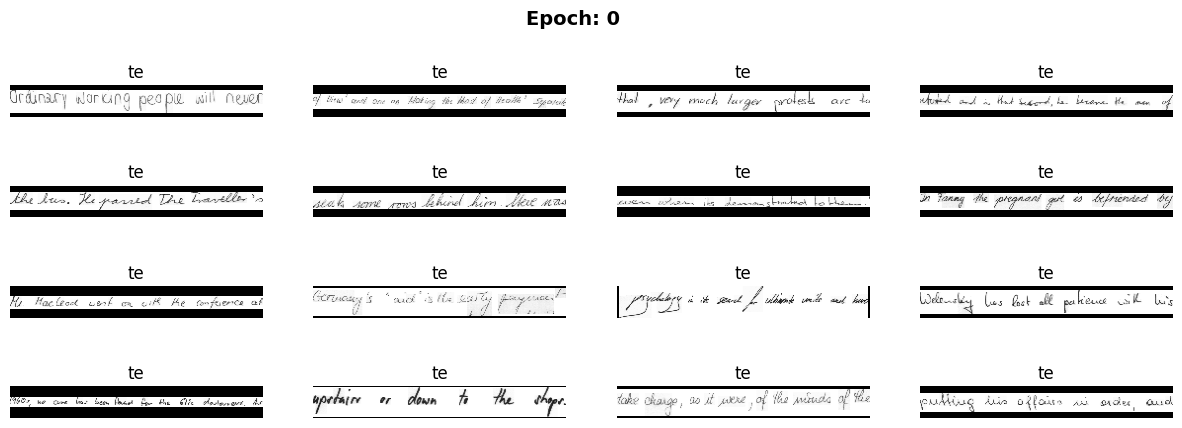

Length: 	 5-10 	| Total: 4 	| CharErrorRate: 0.9259259259259259 	| WordAccuracy: 0.0
Length: 	 10-15 	| Total: 13 	| CharErrorRate: 0.8857142857142857 	| WordAccuracy: 0.0
Length: 	 15-20 	| Total: 9 	| CharErrorRate: 0.9253731343283582 	| WordAccuracy: 0.0
Length: 	 20-25 	| Total: 18 	| CharErrorRate: 0.9281767955801105 	| WordAccuracy: 0.0
Length: 	 25-30 	| Total: 20 	| CharErrorRate: 0.9191919191919192 	| WordAccuracy: 0.0
Length: 	 30-35 	| Total: 43 	| CharErrorRate: 0.9411764705882353 	| WordAccuracy: 0.0
Length: 	 35-40 	| Total: 149 	| CharErrorRate: 0.9478969306555514 	| WordAccuracy: 0.0
Length: 	 40-45 	| Total: 245 	| CharErrorRate: 0.9545500866197901 	| WordAccuracy: 0.0
Length: 	 45-50 	| Total: 266 	| CharErrorRate: 0.9568236967617773 	| WordAccuracy: 0.0
Length: 	 50-55 	| Total: 190 	| CharErrorRate: 0.9607615018508725 	| WordAccuracy: 0.0
Length: 	 55-60 	| Total: 106 	| CharErrorRate: 0.9645743766122098 	| WordAccuracy: 0.0
Length: 	 60-65 	| Total: 46 	| CharError

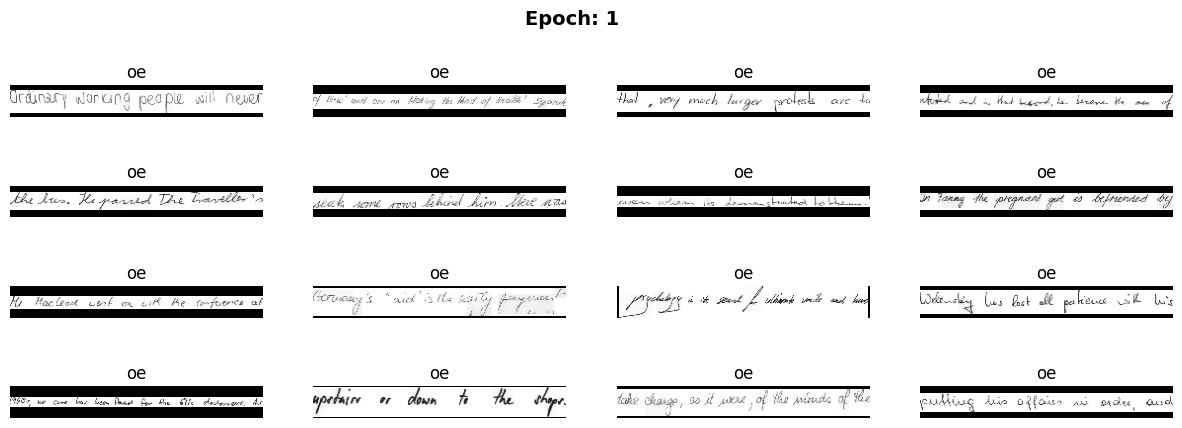

Length: 	 5-10 	| Total: 4 	| CharErrorRate: 0.9629629629629629 	| WordAccuracy: 0.0
Length: 	 10-15 	| Total: 13 	| CharErrorRate: 0.8857142857142857 	| WordAccuracy: 0.0
Length: 	 15-20 	| Total: 9 	| CharErrorRate: 0.9253731343283582 	| WordAccuracy: 0.0
Length: 	 20-25 	| Total: 18 	| CharErrorRate: 0.919889502762431 	| WordAccuracy: 0.0
Length: 	 25-30 	| Total: 20 	| CharErrorRate: 0.9353535353535354 	| WordAccuracy: 0.0
Length: 	 30-35 	| Total: 43 	| CharErrorRate: 0.9427244582043344 	| WordAccuracy: 0.0
Length: 	 35-40 	| Total: 149 	| CharErrorRate: 0.9490337248957939 	| WordAccuracy: 0.0
Length: 	 40-45 	| Total: 245 	| CharErrorRate: 0.954855803525935 	| WordAccuracy: 0.0
Length: 	 45-50 	| Total: 266 	| CharErrorRate: 0.9589155719186679 	| WordAccuracy: 0.0
Length: 	 50-55 	| Total: 190 	| CharErrorRate: 0.9609730301427816 	| WordAccuracy: 0.0
Length: 	 55-60 	| Total: 106 	| CharErrorRate: 0.9647463456577816 	| WordAccuracy: 0.0
Length: 	 60-65 	| Total: 46 	| CharErrorRa

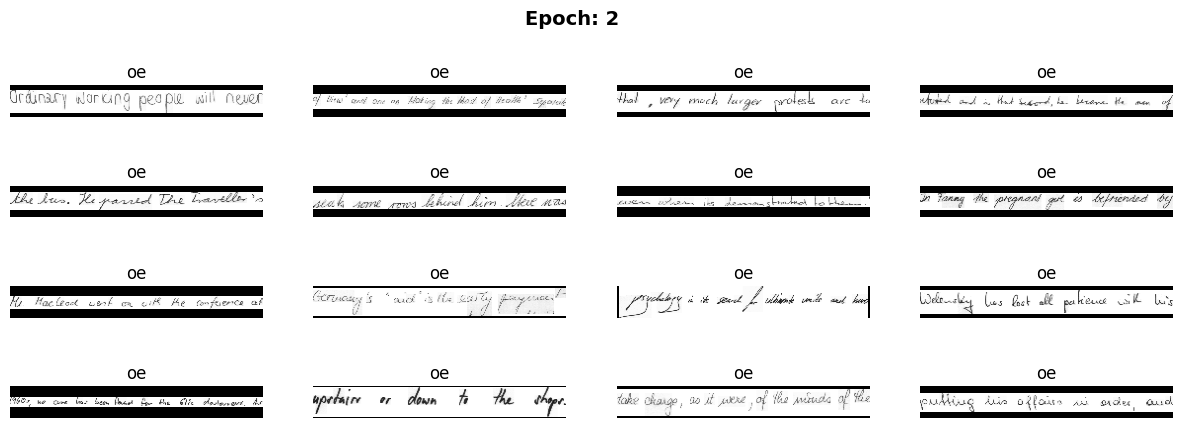

Length: 	 5-10 	| Total: 4 	| CharErrorRate: 0.9629629629629629 	| WordAccuracy: 0.0
Length: 	 10-15 	| Total: 13 	| CharErrorRate: 0.8857142857142857 	| WordAccuracy: 0.0
Length: 	 15-20 	| Total: 9 	| CharErrorRate: 0.9253731343283582 	| WordAccuracy: 0.0
Length: 	 20-25 	| Total: 18 	| CharErrorRate: 0.919889502762431 	| WordAccuracy: 0.0
Length: 	 25-30 	| Total: 20 	| CharErrorRate: 0.9353535353535354 	| WordAccuracy: 0.0
Length: 	 30-35 	| Total: 43 	| CharErrorRate: 0.9427244582043344 	| WordAccuracy: 0.0
Length: 	 35-40 	| Total: 149 	| CharErrorRate: 0.9490337248957939 	| WordAccuracy: 0.0
Length: 	 40-45 	| Total: 245 	| CharErrorRate: 0.954855803525935 	| WordAccuracy: 0.0
Length: 	 45-50 	| Total: 266 	| CharErrorRate: 0.9589155719186679 	| WordAccuracy: 0.0
Length: 	 50-55 	| Total: 190 	| CharErrorRate: 0.9609730301427816 	| WordAccuracy: 0.0
Length: 	 55-60 	| Total: 106 	| CharErrorRate: 0.9647463456577816 	| WordAccuracy: 0.0
Length: 	 60-65 	| Total: 46 	| CharErrorRa

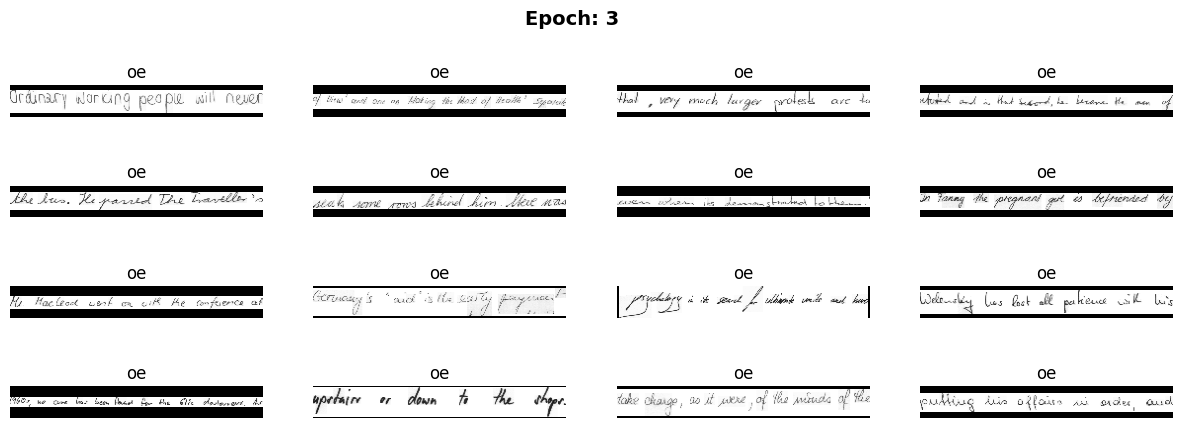

Length: 	 5-10 	| Total: 4 	| CharErrorRate: 0.9629629629629629 	| WordAccuracy: 0.0
Length: 	 10-15 	| Total: 13 	| CharErrorRate: 0.8857142857142857 	| WordAccuracy: 0.0
Length: 	 15-20 	| Total: 9 	| CharErrorRate: 0.9253731343283582 	| WordAccuracy: 0.0
Length: 	 20-25 	| Total: 18 	| CharErrorRate: 0.919889502762431 	| WordAccuracy: 0.0
Length: 	 25-30 	| Total: 20 	| CharErrorRate: 0.9353535353535354 	| WordAccuracy: 0.0
Length: 	 30-35 	| Total: 43 	| CharErrorRate: 0.9427244582043344 	| WordAccuracy: 0.0
Length: 	 35-40 	| Total: 149 	| CharErrorRate: 0.9490337248957939 	| WordAccuracy: 0.0
Length: 	 40-45 	| Total: 245 	| CharErrorRate: 0.954855803525935 	| WordAccuracy: 0.0
Length: 	 45-50 	| Total: 266 	| CharErrorRate: 0.9589155719186679 	| WordAccuracy: 0.0
Length: 	 50-55 	| Total: 190 	| CharErrorRate: 0.9609730301427816 	| WordAccuracy: 0.0
Length: 	 55-60 	| Total: 106 	| CharErrorRate: 0.9647463456577816 	| WordAccuracy: 0.0
Length: 	 60-65 	| Total: 46 	| CharErrorRa

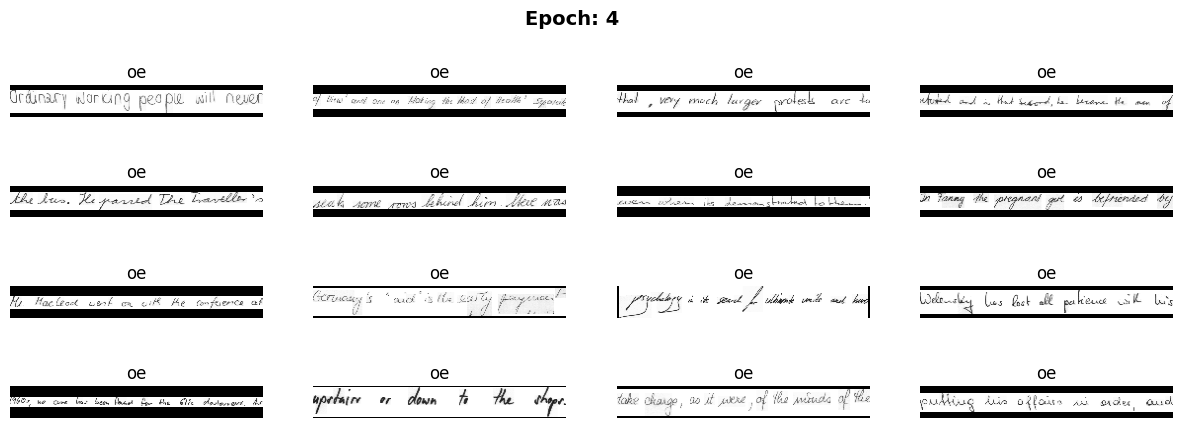

Length: 	 5-10 	| Total: 4 	| CharErrorRate: 0.9629629629629629 	| WordAccuracy: 0.0
Length: 	 10-15 	| Total: 13 	| CharErrorRate: 0.8857142857142857 	| WordAccuracy: 0.0
Length: 	 15-20 	| Total: 9 	| CharErrorRate: 0.9253731343283582 	| WordAccuracy: 0.0
Length: 	 20-25 	| Total: 18 	| CharErrorRate: 0.919889502762431 	| WordAccuracy: 0.0
Length: 	 25-30 	| Total: 20 	| CharErrorRate: 0.9353535353535354 	| WordAccuracy: 0.0
Length: 	 30-35 	| Total: 43 	| CharErrorRate: 0.9427244582043344 	| WordAccuracy: 0.0
Length: 	 35-40 	| Total: 149 	| CharErrorRate: 0.9490337248957939 	| WordAccuracy: 0.0
Length: 	 40-45 	| Total: 245 	| CharErrorRate: 0.954855803525935 	| WordAccuracy: 0.0
Length: 	 45-50 	| Total: 266 	| CharErrorRate: 0.9589155719186679 	| WordAccuracy: 0.0
Length: 	 50-55 	| Total: 190 	| CharErrorRate: 0.9609730301427816 	| WordAccuracy: 0.0
Length: 	 55-60 	| Total: 106 	| CharErrorRate: 0.9647463456577816 	| WordAccuracy: 0.0
Length: 	 60-65 	| Total: 46 	| CharErrorRa

In [ ]:
prediction_model = tf.keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense").output
)

file_path = "drive/MyDrive/Dataset/checkpoint3"
    
checkpoint = ModelCheckpoint(filepath=file_path, 
                            monitor='val_loss', 
                            verbose=1, 
                            save_best_only=True, 
                            mode='min')

# Train the model.
history = model.fit(
    aug_train_ds,
    validation_data=validation_ds,
    epochs=100,
    callbacks=[PlotPredictions(frequency=1, pred_model=prediction_model), EditDistanceCallback(prediction_model), checkpoint])